## Imports

In [2]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [3]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


In [4]:
importlib.reload(data)
eigen_energies, emin, emax = data.load_eigenenergies(unpack = True, n_structures = n_structures)

This file contains the eigenenergies and their corresponding kpoints of the training Silicon structures generated using DFT PBE as implemented in FHI-AIMS version 171221_1 with the ``tight'' settings


In [5]:
print (emin)

-24.553719539983


In [6]:
print (emax)

11.346414696331


In [7]:
# gb = 0.3 #eV
# dE = 0.05 #eV

# # build the DOS of the dataset, 
# # normalized by number of atoms and number of eigenvalues
# xdos2, ldos2 = utils.build_dos(gb, eigen_energies, dE, emin, emax, n_atoms) #sigma, eigenvalues, dx, emin, emax

# xdos2_tensor = torch.tensor(xdos2)
# ldos2 *= 2
# ldos2 = torch.tensor(ldos2)

## Features PCA

In [8]:
from sklearn.decomposition import PCA

soap = Silicon.Features['structure_avedescriptors'] 
soap_pca = PCA(n_components = 1, svd_solver = "full")
soap_pca.fit(soap)

print ("SOAP PCA explained variance with 1 PCA is: {}".format(soap_pca.explained_variance_ratio_))

PCA_soap = soap_pca.transform(soap)

kernel = Silicon.Features['structure_avekerneldescriptors']
kernel_pca = PCA(n_components = 1, svd_solver = "full")
kernel_pca.fit(kernel)

print ("Kernel PCA explained variance with 1 PCA is: {}".format(kernel_pca.explained_variance_ratio_))

PCA_kernel = kernel_pca.transform(kernel)

SOAP PCA explained variance with 1 PCA is: [0.85417772]
Kernel PCA explained variance with 1 PCA is: [0.76640756]


## Variance Minimization

In [10]:
sigma = 0.3
dx = 0.05

full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
eigenenergy_length = [len(i) for i in full_eigen_energies]
eigenenergy_length_t = torch.tensor(eigenenergy_length)
small_index = (eigenenergy_length_t<10000)
small_index = small_index.nonzero()
small_index = small_index.flatten()
n_atoms_t = torch.tensor(n_atoms[small_index])
normalization_eiglength = [len(i) for i in eigen_energies]
normalization_eiglength_t = torch.tensor(normalization_eiglength)
normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms_t/normalization_eiglength_t[small_index]

In [11]:
kernel_features = torch.tensor(PCA_kernel[small_index])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(small_index)))

In [12]:
def generate_energy_index(eigenenergy_length):
    n_structures = len(eigenenergy_length)
    total_index = []
    for i, e_vals in enumerate(eigenenergy_length):
        indiv_index = torch.zeros(e_vals) + i
        total_index.append(indiv_index)
    total_index = torch.hstack(total_index)
    return total_index.long()

In [13]:
energy_index = generate_energy_index(eigenenergy_length)

In [14]:
energies = torch.hstack(full_eigen_energies).view(-1,1)

In [15]:
def torch_generate_dos(energies, eigenenergy_length_t, normalization, splits):
    ldoses = []
    for i in tqdm(range(len(splits) - 1)):
        indexes = generate_energy_index(eigenenergy_length_t[splits[i]:splits[i+1]])
        E = energies[torch.sum(eigenenergy_length_t[:splits[i]]):torch.sum(eigenenergy_length_t[:splits[i]]) + torch.sum(eigenenergy_length_t[splits[i]:splits[i+1]])]
        split_ldos = torch.zeros(splits[i+1] - splits[i], len(xdos))
        
        new_ldos = (torch.exp(-0.5*((xdos - E)/sigma)**2))
        
        split_ldos.index_add_(0, indexes, new_ldos)
        
        ldoses.append(split_ldos)
    ldoses = torch.vstack(ldoses)     
    
    final_ldos = ((ldoses.T * normalization ).T)* 2
    return final_ldos
    


In [16]:
# ldos2 = torch_generate_dos(energies, eigenenergy_length_t, normalization, [0, 100, 200, 300, 400, 500, 800, 1039])

In [17]:
alignment.shape

torch.Size([435])

In [18]:
lr = 100
n_epochs = 1000



In [19]:
sigma = torch.tensor(0.3)
dx = 0.05

emin = -24.5537
emax = 11.3464


ndos = int((emax-emin+3) / dx) #number of points
xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos = torch.zeros((len(small_index), ndos))
for i in tqdm(range(len(small_index))):#for every structure    
    ldos[i] = torch.sum(torch.exp(-0.5*((alignment[i] + xdos - full_eigen_energies[small_index[i]].view(-1,1))/sigma)**2), dim = 0)

final_ldos = ((ldos.T * normalization ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:05<00:00, 75.96it/s]


In [20]:
loss = torch.sum((1 - torch.abs((torch.corrcoef(torch.hstack([kernel_features, final_ldos]).T)[0][1:])))**2)

In [21]:
print (loss)

tensor(212.8861, grad_fn=<SumBackward0>)


In [ ]:
lr = 0.005
# alignment = torch.nn.parameter.Parameter(torch.zeros(len(small_index)))
n_epochs = 100000

optimizer = torch.optim.Adam(
                [alignment],
                lr=lr)#,  line_search_fn="strong_wolfe")

for i in tqdm(range(n_epochs)):
    def closure():
        optimizer.zero_grad()
        sigma = torch.tensor(0.3)
        dx = 0.05

        emin = -24.5537
        emax = 11.3464


        ndos = int((emax-emin+3) / dx) #number of points
        xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
        ldos = torch.zeros((len(small_index), ndos))
        for i in (range(len(small_index))):#for every structure    
            ldos[i] = torch.sum(torch.exp(-0.5*((alignment[i] + xdos - full_eigen_energies[small_index[i]].view(-1,1))/sigma)**2), dim = 0)

        final_ldos = ((ldos.T * normalization ).T)* 2
        pc_loss = torch.sum((1 - torch.abs((torch.corrcoef(torch.hstack([kernel_features, final_ldos]).T)[0][1:])))**2)
        #print (pc_loss)
        pc_loss.backward()
        return pc_loss
    
    mse = optimizer.step(closure)
    
    print (mse)

  0%|                                                                                                                                                              | 1/100000 [01:23<2332:10:58, 83.96s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                              | 2/100000 [02:43<2253:17:55, 81.12s/it]

tensor(166.7246, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                              | 3/100000 [04:03<2240:32:03, 80.66s/it]

tensor(164.8353, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                              | 4/100000 [05:22<2227:39:07, 80.20s/it]

tensor(165.0686, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                              | 5/100000 [06:44<2240:40:59, 80.67s/it]

tensor(165.7550, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                              | 6/100000 [08:07<2267:19:46, 81.63s/it]

tensor(165.7180, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                              | 7/100000 [09:32<2292:11:35, 82.52s/it]

tensor(165.2326, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                              | 8/100000 [11:06<2401:39:58, 86.47s/it]

tensor(164.8136, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                              | 9/100000 [12:21<2301:28:13, 82.86s/it]

tensor(164.7856, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 10/100000 [13:48<2331:23:51, 83.94s/it]

tensor(165.0706, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 11/100000 [15:13<2342:37:40, 84.34s/it]

tensor(165.2523, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 12/100000 [16:40<2367:55:13, 85.26s/it]

tensor(165.1251, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 13/100000 [18:08<2391:58:06, 86.12s/it]

tensor(164.8635, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 14/100000 [19:40<2434:24:33, 87.65s/it]

tensor(164.7274, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 15/100000 [21:09<2452:17:02, 88.30s/it]

tensor(164.7896, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 16/100000 [22:44<2507:45:59, 90.29s/it]

tensor(164.9275, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 17/100000 [24:14<2504:48:51, 90.19s/it]

tensor(164.9909, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 18/100000 [25:46<2519:40:05, 90.72s/it]

tensor(164.9322, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 19/100000 [27:20<2543:53:59, 91.60s/it]

tensor(164.8127, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 20/100000 [28:53<2555:32:01, 92.02s/it]

tensor(164.7324, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 21/100000 [30:26<2560:53:29, 92.21s/it]

tensor(164.7471, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 22/100000 [31:57<2558:05:26, 92.11s/it]

tensor(164.8191, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 23/100000 [33:27<2540:26:57, 91.48s/it]

tensor(164.8581, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 24/100000 [35:03<2576:59:23, 92.79s/it]

tensor(164.8233, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 25/100000 [36:35<2571:10:17, 92.59s/it]

tensor(164.7564, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 26/100000 [38:09<2583:24:34, 93.03s/it]

tensor(164.7220, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 27/100000 [39:43<2590:14:15, 93.27s/it]

tensor(164.7401, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 28/100000 [41:18<2605:14:55, 93.82s/it]

tensor(164.7776, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 29/100000 [42:52<2602:15:09, 93.71s/it]

tensor(164.7915, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 30/100000 [44:24<2588:45:46, 93.22s/it]

tensor(164.7697, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 31/100000 [45:59<2607:40:09, 93.91s/it]

tensor(164.7353, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 32/100000 [47:32<2592:44:30, 93.37s/it]

tensor(164.7196, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 33/100000 [49:04<2586:16:34, 93.14s/it]

tensor(164.7319, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 34/100000 [50:40<2605:50:48, 93.84s/it]

tensor(164.7519, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 35/100000 [52:15<2619:15:36, 94.33s/it]

tensor(164.7542, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 36/100000 [53:49<2611:37:40, 94.05s/it]

tensor(164.7367, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 37/100000 [55:20<2591:15:57, 93.32s/it]

tensor(164.7190, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 38/100000 [56:55<2601:21:28, 93.68s/it]

tensor(164.7176, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 39/100000 [58:30<2619:05:43, 94.32s/it]

tensor(164.7290, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                             | 40/100000 [59:59<2572:37:02, 92.65s/it]

tensor(164.7371, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 41/100000 [1:01:32<2574:29:31, 92.72s/it]

tensor(164.7323, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 42/100000 [1:03:08<2600:34:02, 93.66s/it]

tensor(164.7207, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 43/100000 [1:04:38<2573:22:11, 92.68s/it]

tensor(164.7147, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 44/100000 [1:06:15<2604:37:24, 93.81s/it]

tensor(164.7188, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 45/100000 [1:07:51<2628:05:23, 94.65s/it]

tensor(164.7255, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 46/100000 [1:09:26<2629:17:11, 94.70s/it]

tensor(164.7253, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 47/100000 [1:11:05<2660:08:53, 95.81s/it]

tensor(164.7186, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 48/100000 [1:12:36<2621:41:08, 94.43s/it]

tensor(164.7136, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 49/100000 [1:14:13<2646:22:34, 95.32s/it]

tensor(164.7149, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 50/100000 [1:15:49<2653:14:44, 95.56s/it]

tensor(164.7192, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 51/100000 [1:17:24<2645:59:52, 95.30s/it]

tensor(164.7203, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 52/100000 [1:19:01<2659:01:22, 95.77s/it]

tensor(164.7170, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 53/100000 [1:20:33<2625:52:03, 94.58s/it]

tensor(164.7134, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 54/100000 [1:22:10<2646:54:03, 95.34s/it]

tensor(164.7133, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 55/100000 [1:23:48<2672:58:14, 96.28s/it]

tensor(164.7158, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 56/100000 [1:25:23<2660:50:52, 95.84s/it]

tensor(164.7169, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 57/100000 [1:26:55<2628:35:38, 94.68s/it]

tensor(164.7150, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 58/100000 [1:28:28<2613:43:08, 94.15s/it]

tensor(164.7127, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 59/100000 [1:30:01<2606:01:34, 93.87s/it]

tensor(164.7126, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 60/100000 [1:31:32<2576:22:46, 92.81s/it]

tensor(164.7142, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 61/100000 [1:33:05<2584:03:39, 93.08s/it]

tensor(164.7149, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 62/100000 [1:34:43<2621:40:01, 94.44s/it]

tensor(164.7137, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 63/100000 [1:36:18<2625:11:32, 94.57s/it]

tensor(164.7123, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 64/100000 [1:37:51<2612:10:30, 94.10s/it]

tensor(164.7123, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 65/100000 [1:39:22<2591:32:38, 93.36s/it]

tensor(164.7132, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 66/100000 [1:40:52<2560:22:35, 92.23s/it]

tensor(164.7136, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 67/100000 [1:42:24<2560:25:10, 92.24s/it]

tensor(164.7128, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 68/100000 [1:43:56<2558:15:24, 92.16s/it]

tensor(164.7120, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 69/100000 [1:45:30<2573:18:44, 92.70s/it]

tensor(164.7122, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 70/100000 [1:47:01<2561:16:32, 92.27s/it]

tensor(164.7128, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 71/100000 [1:48:34<2561:07:04, 92.27s/it]

tensor(164.7128, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 72/100000 [1:50:04<2540:58:50, 91.54s/it]

tensor(164.7123, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 73/100000 [1:51:32<2516:39:19, 90.67s/it]

tensor(164.7119, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 74/100000 [1:53:05<2537:58:43, 91.43s/it]

tensor(164.7121, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 75/100000 [1:54:41<2574:05:57, 92.74s/it]

tensor(164.7124, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 76/100000 [1:56:17<2598:38:06, 93.62s/it]

tensor(164.7123, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 77/100000 [1:57:51<2602:51:27, 93.78s/it]

tensor(164.7119, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 78/100000 [1:59:26<2612:14:09, 94.11s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 79/100000 [2:01:02<2629:41:12, 94.74s/it]

tensor(164.7120, grad_fn=<SumBackward0>)


  0%|                                                                                                                                                           | 80/100000 [2:02:35<2611:06:36, 94.08s/it]

tensor(164.7122, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 81/100000 [2:04:12<2636:52:09, 95.00s/it]

tensor(164.7120, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 82/100000 [2:05:46<2633:01:18, 94.87s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 83/100000 [2:07:16<2590:32:57, 93.34s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 84/100000 [2:08:50<2595:59:14, 93.53s/it]

tensor(164.7120, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 85/100000 [2:10:24<2600:16:01, 93.69s/it]

tensor(164.7120, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 86/100000 [2:11:57<2589:16:09, 93.29s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 87/100000 [2:13:26<2560:17:08, 92.25s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 88/100000 [2:14:59<2565:48:34, 92.45s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 89/100000 [2:16:35<2590:24:11, 93.34s/it]

tensor(164.7119, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 90/100000 [2:18:08<2589:21:57, 93.30s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 91/100000 [2:19:41<2590:18:17, 93.34s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 92/100000 [2:21:15<2596:58:01, 93.58s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 93/100000 [2:22:48<2587:00:20, 93.22s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 94/100000 [2:24:19<2569:53:24, 92.60s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 95/100000 [2:25:47<2529:48:14, 91.16s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 96/100000 [2:27:19<2535:34:28, 91.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 97/100000 [2:28:55<2572:49:58, 92.71s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 98/100000 [2:30:28<2577:44:27, 92.89s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                          | 99/100000 [2:32:06<2617:58:51, 94.34s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 100/100000 [2:33:44<2655:28:37, 95.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 101/100000 [2:35:21<2662:24:33, 95.94s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 102/100000 [2:36:59<2683:58:58, 96.72s/it]

tensor(164.7118, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 103/100000 [2:38:39<2705:43:37, 97.51s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 104/100000 [2:39:54<2522:38:50, 90.91s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 105/100000 [2:41:24<2514:22:07, 90.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 106/100000 [2:43:03<2579:10:45, 92.95s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 107/100000 [2:44:38<2598:37:25, 93.65s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 108/100000 [2:46:16<2634:02:10, 94.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 109/100000 [2:47:51<2639:09:41, 95.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 110/100000 [2:49:26<2633:43:59, 94.92s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 111/100000 [2:50:57<2605:57:46, 93.92s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 112/100000 [2:52:33<2619:53:16, 94.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 113/100000 [2:54:09<2631:26:11, 94.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 114/100000 [2:55:47<2657:47:48, 95.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 115/100000 [2:57:14<2583:16:03, 93.10s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 116/100000 [2:58:50<2611:46:27, 94.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 117/100000 [3:00:25<2618:21:28, 94.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 118/100000 [3:02:01<2634:46:04, 94.96s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 119/100000 [3:03:38<2650:06:07, 95.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 120/100000 [3:05:14<2649:39:43, 95.50s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 121/100000 [3:06:50<2652:25:43, 95.60s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 122/100000 [3:08:03<2469:16:02, 89.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 123/100000 [3:08:56<2165:11:24, 78.04s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 124/100000 [3:10:08<2118:58:27, 76.38s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 125/100000 [3:11:20<2080:15:16, 74.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 126/100000 [3:12:24<1989:01:07, 71.70s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 127/100000 [3:13:28<1925:57:23, 69.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 128/100000 [3:14:19<1774:42:37, 63.97s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 129/100000 [3:15:18<1733:36:43, 62.49s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 130/100000 [3:16:25<1772:29:30, 63.89s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 131/100000 [3:17:37<1833:55:19, 66.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 132/100000 [3:18:26<1692:51:24, 61.02s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 133/100000 [3:19:29<1708:21:19, 61.58s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 134/100000 [3:20:33<1732:02:37, 62.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 135/100000 [3:21:29<1674:04:08, 60.35s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 136/100000 [3:22:27<1660:00:52, 59.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 137/100000 [3:23:25<1640:20:03, 59.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 138/100000 [3:24:35<1735:45:05, 62.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 139/100000 [3:25:52<1853:47:18, 66.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 140/100000 [3:26:58<1847:21:35, 66.60s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 141/100000 [3:28:08<1870:18:57, 67.43s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 142/100000 [3:29:13<1849:54:28, 66.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 143/100000 [3:30:22<1869:33:18, 67.40s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 144/100000 [3:31:34<1908:59:00, 68.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 145/100000 [3:32:37<1859:53:22, 67.05s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 146/100000 [3:33:28<1725:04:42, 62.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 147/100000 [3:34:21<1655:56:02, 59.70s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 148/100000 [3:35:24<1683:30:02, 60.70s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 149/100000 [3:36:18<1626:48:22, 58.65s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 150/100000 [3:37:20<1650:47:30, 59.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 151/100000 [3:38:22<1673:17:43, 60.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 152/100000 [3:39:32<1751:31:10, 63.15s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 153/100000 [3:40:29<1699:48:24, 61.29s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 154/100000 [3:41:35<1740:14:17, 62.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 155/100000 [3:42:21<1603:45:32, 57.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 156/100000 [3:43:22<1627:08:43, 58.67s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 157/100000 [3:44:32<1724:48:50, 62.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 158/100000 [3:45:44<1806:32:40, 65.14s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 159/100000 [3:46:54<1844:44:41, 66.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 160/100000 [3:47:56<1804:43:30, 65.07s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 161/100000 [3:49:08<1862:01:46, 67.14s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▏                                                                                                                                                         | 162/100000 [3:50:10<1822:29:12, 65.72s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 163/100000 [3:51:28<1927:17:34, 69.50s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 164/100000 [3:52:37<1921:00:30, 69.27s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 165/100000 [3:53:49<1940:43:04, 69.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 166/100000 [3:54:52<1879:42:34, 67.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 167/100000 [3:55:56<1852:32:04, 66.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 168/100000 [3:56:55<1787:13:15, 64.45s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 169/100000 [3:57:50<1707:05:56, 61.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 170/100000 [3:58:52<1715:10:50, 61.85s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 171/100000 [4:00:01<1774:43:10, 64.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 172/100000 [4:01:08<1797:58:54, 64.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 173/100000 [4:02:20<1852:31:58, 66.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 174/100000 [4:03:20<1802:58:47, 65.02s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 175/100000 [4:04:33<1863:35:49, 67.21s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 176/100000 [4:05:31<1790:05:52, 64.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 177/100000 [4:06:33<1767:36:44, 63.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 178/100000 [4:07:39<1784:57:34, 64.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 179/100000 [4:08:34<1711:46:45, 61.73s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 180/100000 [4:09:34<1696:31:26, 61.18s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 181/100000 [4:10:40<1732:35:02, 62.49s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 182/100000 [4:11:46<1766:53:49, 63.72s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 183/100000 [4:12:38<1662:06:47, 59.95s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 184/100000 [4:13:42<1698:51:58, 61.27s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 185/100000 [4:14:45<1714:57:32, 61.85s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 186/100000 [4:15:49<1728:46:12, 62.35s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 187/100000 [4:16:48<1704:43:13, 61.48s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 188/100000 [4:17:53<1733:01:50, 62.51s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 189/100000 [4:19:04<1806:55:18, 65.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 190/100000 [4:20:11<1819:44:54, 65.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 191/100000 [4:21:07<1741:00:04, 62.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 192/100000 [4:22:08<1728:11:04, 62.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 193/100000 [4:23:20<1803:48:29, 65.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 194/100000 [4:24:20<1766:08:30, 63.70s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 195/100000 [4:25:26<1780:20:11, 64.22s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 196/100000 [4:26:34<1809:56:15, 65.29s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 197/100000 [4:27:37<1791:59:29, 64.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 198/100000 [4:28:39<1769:27:45, 63.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 199/100000 [4:29:43<1769:55:46, 63.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 200/100000 [4:30:29<1621:48:33, 58.50s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 201/100000 [4:31:29<1633:39:57, 58.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 202/100000 [4:32:32<1673:36:12, 60.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 203/100000 [4:33:36<1700:23:40, 61.34s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 204/100000 [4:34:30<1636:34:53, 59.04s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 205/100000 [4:35:34<1682:33:34, 60.70s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 206/100000 [4:36:30<1639:19:08, 59.14s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 207/100000 [4:37:22<1584:41:30, 57.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 208/100000 [4:38:08<1491:09:57, 53.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 209/100000 [4:39:03<1497:04:44, 54.01s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 210/100000 [4:40:03<1553:00:36, 56.03s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 211/100000 [4:41:15<1680:18:25, 60.62s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 212/100000 [4:42:18<1706:34:56, 61.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 213/100000 [4:43:26<1752:36:09, 63.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 214/100000 [4:44:38<1828:50:30, 65.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 215/100000 [4:45:52<1895:39:30, 68.39s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 216/100000 [4:46:45<1765:02:34, 63.68s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 217/100000 [4:47:53<1803:18:35, 65.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 218/100000 [4:49:00<1822:20:55, 65.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 219/100000 [4:49:55<1727:46:22, 62.34s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 220/100000 [4:50:57<1730:10:13, 62.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 221/100000 [4:51:53<1673:21:01, 60.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 222/100000 [4:52:48<1630:33:46, 58.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 223/100000 [4:53:45<1612:17:56, 58.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 224/100000 [4:54:43<1610:46:40, 58.12s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 225/100000 [4:55:36<1570:17:08, 56.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 226/100000 [4:56:46<1680:35:45, 60.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 227/100000 [4:57:52<1727:53:35, 62.35s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 228/100000 [4:59:01<1778:11:32, 64.16s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 229/100000 [4:59:57<1717:02:30, 61.96s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 230/100000 [5:01:03<1747:05:00, 63.04s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 231/100000 [5:02:10<1779:17:59, 64.20s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 232/100000 [5:03:14<1779:17:01, 64.20s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 233/100000 [5:04:34<1910:29:16, 68.94s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 234/100000 [5:05:40<1885:19:44, 68.03s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 235/100000 [5:06:47<1876:27:53, 67.71s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 236/100000 [5:07:47<1810:17:29, 65.32s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 237/100000 [5:08:45<1752:27:05, 63.24s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 238/100000 [5:09:44<1714:47:05, 61.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 239/100000 [5:10:44<1699:50:15, 61.34s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 240/100000 [5:11:50<1742:12:21, 62.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 241/100000 [5:12:45<1675:46:03, 60.47s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 242/100000 [5:13:51<1722:49:09, 62.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                         | 243/100000 [5:14:59<1763:38:28, 63.65s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 244/100000 [5:16:05<1783:19:35, 64.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 245/100000 [5:17:04<1740:08:28, 62.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 246/100000 [5:18:08<1749:53:34, 63.15s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 247/100000 [5:19:08<1724:26:26, 62.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 248/100000 [5:20:21<1813:27:38, 65.45s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 249/100000 [5:21:32<1861:33:28, 67.18s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 250/100000 [5:22:35<1831:01:59, 66.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 251/100000 [5:23:41<1828:24:35, 65.99s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 252/100000 [5:24:32<1701:44:34, 61.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 253/100000 [5:25:18<1573:32:27, 56.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 254/100000 [5:26:16<1582:52:36, 57.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 255/100000 [5:27:21<1646:33:12, 59.43s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 256/100000 [5:28:29<1724:16:14, 62.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 257/100000 [5:29:44<1827:01:01, 65.94s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 258/100000 [5:30:50<1825:18:34, 65.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 259/100000 [5:31:51<1786:25:07, 64.48s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 260/100000 [5:32:53<1766:37:33, 63.76s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 261/100000 [5:33:44<1656:27:34, 59.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 262/100000 [5:34:48<1691:38:11, 61.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 263/100000 [5:35:54<1734:00:00, 62.59s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 264/100000 [5:36:59<1759:41:50, 63.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 265/100000 [5:38:06<1788:18:47, 64.55s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 266/100000 [5:39:09<1774:17:16, 64.04s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 267/100000 [5:40:06<1711:31:54, 61.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 268/100000 [5:41:08<1712:57:06, 61.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 269/100000 [5:42:18<1786:43:22, 64.50s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 270/100000 [5:43:25<1803:42:37, 65.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 271/100000 [5:44:36<1849:09:47, 66.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 272/100000 [5:45:48<1893:36:16, 68.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 273/100000 [5:46:50<1845:45:32, 66.63s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 274/100000 [5:47:59<1864:11:53, 67.30s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 275/100000 [5:49:02<1824:58:57, 65.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 276/100000 [5:50:11<1849:44:14, 66.77s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 277/100000 [5:51:17<1847:24:31, 66.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 278/100000 [5:52:16<1779:41:11, 64.25s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 279/100000 [5:53:19<1771:32:16, 63.95s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 280/100000 [5:54:24<1779:30:34, 64.24s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 281/100000 [5:55:25<1755:43:46, 63.38s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 282/100000 [5:56:29<1759:28:16, 63.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 283/100000 [5:57:35<1781:52:38, 64.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 284/100000 [5:58:32<1721:24:04, 62.15s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 285/100000 [5:59:32<1701:15:26, 61.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 286/100000 [6:00:44<1793:02:04, 64.73s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 287/100000 [6:01:48<1783:54:22, 64.41s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 288/100000 [6:02:56<1809:34:25, 65.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 289/100000 [6:03:58<1781:20:26, 64.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 290/100000 [6:05:02<1782:41:54, 64.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 291/100000 [6:06:13<1837:50:47, 66.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 292/100000 [6:07:13<1787:25:47, 64.54s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 293/100000 [6:08:20<1802:35:51, 65.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 294/100000 [6:09:20<1765:54:13, 63.76s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 295/100000 [6:10:23<1753:47:36, 63.32s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 296/100000 [6:11:31<1794:48:49, 64.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 297/100000 [6:12:20<1663:14:58, 60.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 298/100000 [6:13:20<1659:57:03, 59.94s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 299/100000 [6:14:22<1677:39:55, 60.58s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 300/100000 [6:15:24<1689:19:29, 61.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 301/100000 [6:16:39<1806:34:04, 65.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 302/100000 [6:17:42<1787:46:51, 64.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 303/100000 [6:18:50<1821:43:43, 65.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 304/100000 [6:19:56<1819:14:25, 65.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 305/100000 [6:20:57<1781:57:19, 64.35s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 306/100000 [6:21:59<1764:51:58, 63.73s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 307/100000 [6:23:06<1791:51:29, 64.71s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 308/100000 [6:24:09<1779:22:25, 64.26s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 309/100000 [6:25:24<1861:42:21, 67.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 310/100000 [6:26:25<1812:22:16, 65.45s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 311/100000 [6:27:28<1790:40:18, 64.67s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 312/100000 [6:28:35<1808:55:22, 65.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 313/100000 [6:29:37<1780:48:38, 64.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 314/100000 [6:30:38<1752:56:30, 63.30s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 315/100000 [6:31:45<1783:50:15, 64.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 316/100000 [6:32:43<1734:39:46, 62.65s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 317/100000 [6:33:48<1752:14:01, 63.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 318/100000 [6:34:50<1746:38:00, 63.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 319/100000 [6:36:00<1803:45:19, 65.14s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 320/100000 [6:37:01<1769:08:15, 63.89s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 321/100000 [6:37:55<1683:57:26, 60.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 322/100000 [6:38:53<1657:13:28, 59.85s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 323/100000 [6:39:43<1578:09:00, 57.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                         | 324/100000 [6:40:52<1676:01:07, 60.53s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 325/100000 [6:42:05<1780:21:58, 64.30s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 326/100000 [6:43:12<1802:54:21, 65.12s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 327/100000 [6:44:22<1841:42:51, 66.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 328/100000 [6:45:15<1732:35:13, 62.58s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 329/100000 [6:46:15<1712:14:04, 61.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 330/100000 [6:47:09<1645:23:42, 59.43s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 331/100000 [6:48:09<1654:05:56, 59.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 332/100000 [6:49:16<1714:00:45, 61.91s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 333/100000 [6:50:09<1638:37:09, 59.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 334/100000 [6:50:59<1556:21:26, 56.22s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 335/100000 [6:52:14<1712:27:42, 61.86s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 336/100000 [6:53:13<1690:52:25, 61.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 337/100000 [6:54:18<1721:27:52, 62.18s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 338/100000 [6:55:12<1657:47:54, 59.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 339/100000 [6:56:05<1600:17:48, 57.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 340/100000 [6:57:09<1647:58:46, 59.53s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 341/100000 [6:58:07<1642:01:31, 59.32s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 342/100000 [6:58:55<1546:15:11, 55.86s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 343/100000 [7:00:03<1641:17:05, 59.29s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 344/100000 [7:01:05<1664:43:34, 60.14s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 345/100000 [7:02:15<1752:25:04, 63.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 346/100000 [7:03:23<1787:06:36, 64.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 347/100000 [7:04:25<1764:48:33, 63.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 348/100000 [7:05:38<1845:36:35, 66.67s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 349/100000 [7:06:26<1690:46:21, 61.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 350/100000 [7:07:13<1574:00:50, 56.86s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 351/100000 [7:08:16<1622:53:30, 58.63s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 352/100000 [7:09:14<1621:09:59, 58.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 353/100000 [7:10:10<1593:33:54, 57.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 354/100000 [7:11:13<1642:47:17, 59.35s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 355/100000 [7:12:16<1670:54:20, 60.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 356/100000 [7:13:19<1689:51:25, 61.05s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 357/100000 [7:14:32<1792:14:22, 64.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 358/100000 [7:15:41<1831:29:21, 66.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 359/100000 [7:16:52<1869:02:07, 67.53s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 360/100000 [7:18:06<1918:37:34, 69.32s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 361/100000 [7:19:05<1835:09:57, 66.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 362/100000 [7:20:07<1803:29:26, 65.16s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 363/100000 [7:21:12<1803:08:25, 65.15s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 364/100000 [7:22:11<1746:04:51, 63.09s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 365/100000 [7:23:12<1729:06:29, 62.48s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 366/100000 [7:24:11<1703:09:10, 61.54s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 367/100000 [7:25:09<1676:05:14, 60.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 368/100000 [7:26:07<1647:55:54, 59.54s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 369/100000 [7:27:08<1662:01:14, 60.05s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 370/100000 [7:28:18<1744:17:56, 63.03s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 371/100000 [7:29:37<1878:44:35, 67.89s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 372/100000 [7:30:43<1864:29:40, 67.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 373/100000 [7:31:48<1843:47:04, 66.62s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 374/100000 [7:32:48<1791:52:45, 64.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 375/100000 [7:33:50<1768:48:47, 63.92s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 376/100000 [7:34:51<1743:51:45, 63.02s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 377/100000 [7:35:50<1704:58:46, 61.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 378/100000 [7:36:54<1730:30:41, 62.53s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 379/100000 [7:37:56<1718:57:34, 62.12s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 380/100000 [7:38:48<1642:38:18, 59.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 381/100000 [7:39:51<1672:13:35, 60.43s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 382/100000 [7:40:53<1683:47:05, 60.85s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 383/100000 [7:42:03<1760:27:48, 63.62s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 384/100000 [7:43:02<1719:10:26, 62.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 385/100000 [7:44:08<1752:22:57, 63.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 386/100000 [7:45:07<1715:40:20, 62.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 387/100000 [7:46:00<1641:53:38, 59.34s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 388/100000 [7:46:59<1640:11:58, 59.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 389/100000 [7:47:51<1580:18:20, 57.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 390/100000 [7:48:52<1612:53:53, 58.29s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 391/100000 [7:49:47<1585:06:27, 57.29s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 392/100000 [7:50:57<1684:46:29, 60.89s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 393/100000 [7:51:50<1621:39:43, 58.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 394/100000 [7:52:57<1692:21:45, 61.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 395/100000 [7:54:07<1767:26:39, 63.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 396/100000 [7:55:11<1765:16:30, 63.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 397/100000 [7:56:04<1673:10:45, 60.47s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 398/100000 [7:57:14<1756:09:09, 63.47s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 399/100000 [7:58:13<1715:27:57, 62.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 400/100000 [7:59:17<1739:19:50, 62.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 401/100000 [8:00:11<1661:07:51, 60.04s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 402/100000 [8:01:14<1686:50:03, 60.97s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 403/100000 [8:02:28<1796:01:12, 64.92s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 404/100000 [8:03:30<1768:50:17, 63.94s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▌                                                                                                                                                         | 405/100000 [8:04:33<1763:31:55, 63.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 406/100000 [8:05:34<1739:12:37, 62.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 407/100000 [8:06:36<1736:28:48, 62.77s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 408/100000 [8:07:47<1802:29:55, 65.16s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 409/100000 [8:08:43<1725:06:34, 62.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 410/100000 [8:09:58<1832:49:18, 66.25s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 411/100000 [8:11:04<1827:58:49, 66.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 412/100000 [8:12:12<1841:48:33, 66.58s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 413/100000 [8:13:18<1840:10:42, 66.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 414/100000 [8:14:13<1741:40:31, 62.96s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 415/100000 [8:15:04<1644:14:01, 59.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 416/100000 [8:16:16<1749:13:00, 63.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 417/100000 [8:17:31<1847:14:17, 66.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 418/100000 [8:18:37<1841:53:14, 66.59s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 419/100000 [8:19:28<1706:36:21, 61.70s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 420/100000 [8:20:30<1715:41:10, 62.03s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 421/100000 [8:21:38<1765:09:32, 63.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 422/100000 [8:22:44<1778:25:45, 64.29s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 423/100000 [8:23:47<1769:21:23, 63.97s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 424/100000 [8:24:51<1769:28:16, 63.97s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 425/100000 [8:25:52<1748:45:48, 63.22s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 426/100000 [8:26:54<1733:59:38, 62.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 427/100000 [8:28:00<1760:08:35, 63.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 428/100000 [8:28:58<1716:42:33, 62.07s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 429/100000 [8:29:56<1680:37:07, 60.76s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 430/100000 [8:30:58<1694:51:13, 61.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 431/100000 [8:32:00<1699:45:24, 61.46s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 432/100000 [8:32:49<1592:00:10, 57.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 433/100000 [8:33:49<1613:19:54, 58.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 434/100000 [8:34:54<1667:13:40, 60.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 435/100000 [8:35:49<1628:06:07, 58.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 436/100000 [8:36:37<1536:58:30, 55.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 437/100000 [8:37:28<1499:35:57, 54.22s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 438/100000 [8:38:36<1612:23:32, 58.30s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 439/100000 [8:39:49<1730:22:05, 62.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 440/100000 [8:41:02<1818:41:11, 65.76s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 441/100000 [8:42:11<1848:20:50, 66.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 442/100000 [8:43:25<1904:22:52, 68.86s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 443/100000 [8:44:23<1813:31:24, 65.58s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 444/100000 [8:45:28<1808:47:28, 65.41s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 445/100000 [8:46:32<1797:30:10, 65.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 446/100000 [8:47:32<1756:28:38, 63.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 447/100000 [8:48:40<1799:51:54, 65.09s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 448/100000 [8:49:48<1816:15:41, 65.68s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 449/100000 [8:50:51<1797:58:04, 65.02s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 450/100000 [8:51:52<1763:49:49, 63.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 451/100000 [8:52:56<1762:28:14, 63.74s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 452/100000 [8:54:07<1828:07:40, 66.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 453/100000 [8:55:16<1850:45:59, 66.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 454/100000 [8:56:30<1907:37:03, 68.99s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 455/100000 [8:57:41<1926:08:07, 69.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 456/100000 [8:58:47<1892:21:42, 68.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 457/100000 [8:59:48<1831:45:48, 66.25s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 458/100000 [9:00:55<1842:35:26, 66.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 459/100000 [9:02:00<1827:13:00, 66.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 460/100000 [9:02:59<1770:24:04, 64.03s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 461/100000 [9:04:07<1798:52:42, 65.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 462/100000 [9:05:09<1776:14:22, 64.24s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 463/100000 [9:06:09<1739:25:18, 62.91s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 464/100000 [9:07:05<1685:25:51, 60.96s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 465/100000 [9:08:05<1675:54:09, 60.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 466/100000 [9:09:13<1738:35:03, 62.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 467/100000 [9:10:19<1759:35:05, 63.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 468/100000 [9:11:20<1737:03:53, 62.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 469/100000 [9:12:24<1745:25:20, 63.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 470/100000 [9:13:29<1762:58:54, 63.77s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 471/100000 [9:14:36<1795:12:11, 64.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 472/100000 [9:15:43<1807:28:16, 65.38s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 473/100000 [9:16:51<1826:59:24, 66.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 474/100000 [9:17:58<1838:27:29, 66.50s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 475/100000 [9:18:53<1739:03:41, 62.91s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 476/100000 [9:19:52<1713:30:23, 61.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 477/100000 [9:21:02<1774:53:58, 64.20s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 478/100000 [9:22:10<1808:18:57, 65.41s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 479/100000 [9:23:18<1829:09:04, 66.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 480/100000 [9:24:31<1882:44:19, 68.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 481/100000 [9:25:42<1909:50:45, 69.09s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 482/100000 [9:26:51<1911:09:42, 69.14s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 483/100000 [9:27:59<1897:30:57, 68.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 484/100000 [9:29:02<1850:48:39, 66.95s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 485/100000 [9:29:57<1752:18:17, 63.39s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 486/100000 [9:31:03<1776:34:41, 64.27s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                         | 487/100000 [9:32:14<1834:15:18, 66.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 488/100000 [9:33:13<1769:02:39, 64.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 489/100000 [9:34:21<1800:09:14, 65.12s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 490/100000 [9:35:24<1786:58:17, 64.65s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 491/100000 [9:36:24<1746:49:56, 63.20s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 492/100000 [9:37:35<1815:15:52, 65.67s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 493/100000 [9:38:39<1801:13:23, 65.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 494/100000 [9:39:36<1733:14:46, 62.71s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 495/100000 [9:40:42<1756:37:20, 63.55s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 496/100000 [9:41:44<1741:02:50, 62.99s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 497/100000 [9:42:39<1682:21:40, 60.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 498/100000 [9:43:34<1628:47:31, 58.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 499/100000 [9:44:35<1649:03:13, 59.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                         | 500/100000 [9:45:44<1722:31:58, 62.32s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 501/100000 [9:46:49<1749:41:58, 63.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 502/100000 [9:47:40<1645:40:27, 59.54s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 503/100000 [9:48:47<1710:16:30, 61.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 504/100000 [9:49:57<1773:34:03, 64.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 505/100000 [9:50:49<1674:30:56, 60.59s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 506/100000 [9:52:00<1759:25:07, 63.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 507/100000 [9:53:02<1742:50:13, 63.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 508/100000 [9:54:12<1803:49:03, 65.27s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 509/100000 [9:55:04<1695:30:18, 61.35s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 510/100000 [9:55:59<1641:39:41, 59.40s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 511/100000 [9:57:09<1728:19:36, 62.54s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 512/100000 [9:58:01<1639:57:30, 59.34s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                         | 513/100000 [9:59:12<1735:35:28, 62.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 514/100000 [10:00:09<1687:35:56, 61.07s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 515/100000 [10:01:19<1765:45:28, 63.90s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 516/100000 [10:02:01<1581:46:52, 57.24s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 517/100000 [10:02:59<1583:57:33, 57.32s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 518/100000 [10:03:54<1566:40:35, 56.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 519/100000 [10:04:53<1587:32:49, 57.45s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 520/100000 [10:05:56<1629:53:22, 58.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 521/100000 [10:07:02<1690:23:04, 61.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 522/100000 [10:08:06<1716:31:42, 62.12s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 523/100000 [10:09:04<1681:30:35, 60.85s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 524/100000 [10:10:17<1778:55:36, 64.38s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 525/100000 [10:11:31<1857:37:00, 67.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 526/100000 [10:12:29<1784:23:04, 64.58s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 527/100000 [10:13:24<1701:50:53, 61.59s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 528/100000 [10:14:24<1688:34:24, 61.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 529/100000 [10:15:18<1636:19:29, 59.22s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 530/100000 [10:16:19<1651:33:22, 59.77s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 531/100000 [10:17:18<1645:17:53, 59.55s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 532/100000 [10:18:24<1696:21:40, 61.40s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 533/100000 [10:19:15<1610:56:14, 58.30s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 534/100000 [10:20:11<1591:55:05, 57.62s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 535/100000 [10:21:04<1549:24:32, 56.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 536/100000 [10:21:54<1500:36:08, 54.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 537/100000 [10:22:54<1545:55:51, 55.95s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 538/100000 [10:24:03<1653:01:27, 59.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 539/100000 [10:25:12<1735:02:24, 62.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 540/100000 [10:26:32<1875:15:17, 67.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 541/100000 [10:27:35<1834:31:39, 66.40s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 542/100000 [10:28:30<1743:49:19, 63.12s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 543/100000 [10:29:35<1758:55:13, 63.67s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 544/100000 [10:30:21<1608:00:55, 58.21s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 545/100000 [10:31:34<1735:49:26, 62.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 546/100000 [10:32:26<1641:42:36, 59.43s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 547/100000 [10:33:31<1688:53:26, 61.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 548/100000 [10:34:38<1736:53:35, 62.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 549/100000 [10:35:27<1624:25:37, 58.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 550/100000 [10:36:38<1721:25:16, 62.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 551/100000 [10:37:46<1768:12:16, 64.01s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 552/100000 [10:38:48<1752:28:33, 63.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 553/100000 [10:39:52<1761:42:39, 63.77s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 554/100000 [10:41:01<1804:32:19, 65.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 555/100000 [10:42:00<1744:44:11, 63.16s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 556/100000 [10:43:10<1809:30:41, 65.51s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 557/100000 [10:44:15<1800:26:13, 65.18s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 558/100000 [10:45:20<1800:03:14, 65.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 559/100000 [10:46:10<1673:09:33, 60.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 560/100000 [10:46:58<1569:49:22, 56.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 561/100000 [10:47:56<1582:52:59, 57.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 562/100000 [10:48:59<1627:43:24, 58.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 563/100000 [10:50:05<1682:27:27, 60.91s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 564/100000 [10:51:12<1733:56:37, 62.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 565/100000 [10:52:22<1793:35:34, 64.94s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 566/100000 [10:53:06<1622:18:20, 58.74s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 567/100000 [10:54:17<1725:38:21, 62.48s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 568/100000 [10:55:08<1629:40:14, 59.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 569/100000 [10:56:06<1617:31:45, 58.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 570/100000 [10:57:16<1717:09:27, 62.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▊                                                                                                                                                        | 571/100000 [10:58:26<1782:35:10, 64.54s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 572/100000 [10:59:41<1863:22:08, 67.47s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 573/100000 [11:00:41<1805:32:26, 65.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 574/100000 [11:01:46<1799:49:48, 65.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 575/100000 [11:02:57<1848:36:40, 66.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 576/100000 [11:04:06<1870:51:10, 67.74s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 577/100000 [11:05:13<1856:33:06, 67.22s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 578/100000 [11:06:24<1894:38:40, 68.60s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 579/100000 [11:07:30<1868:52:44, 67.67s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 580/100000 [11:08:33<1829:05:01, 66.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 581/100000 [11:09:29<1750:31:10, 63.39s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 582/100000 [11:10:30<1730:11:08, 62.65s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 583/100000 [11:11:33<1730:09:35, 62.65s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 584/100000 [11:12:40<1768:24:05, 64.04s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 585/100000 [11:13:40<1729:45:09, 62.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 586/100000 [11:14:48<1780:02:35, 64.46s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 587/100000 [11:15:50<1759:32:11, 63.72s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 588/100000 [11:16:52<1742:29:13, 63.10s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 589/100000 [11:17:47<1675:22:26, 60.67s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 590/100000 [11:18:58<1758:44:07, 63.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 591/100000 [11:20:07<1804:55:43, 65.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 592/100000 [11:21:12<1802:37:59, 65.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 593/100000 [11:22:19<1816:35:52, 65.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 594/100000 [11:23:19<1769:50:31, 64.10s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 595/100000 [11:24:11<1666:33:19, 60.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 596/100000 [11:25:20<1739:16:15, 62.99s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 597/100000 [11:26:20<1713:44:47, 62.07s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 598/100000 [11:27:31<1790:18:21, 64.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 599/100000 [11:28:36<1793:02:23, 64.94s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 600/100000 [11:29:33<1723:52:35, 62.43s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 601/100000 [11:30:37<1734:15:33, 62.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 602/100000 [11:31:42<1758:37:11, 63.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 603/100000 [11:32:37<1680:07:56, 60.85s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 604/100000 [11:33:34<1653:03:50, 59.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 605/100000 [11:34:37<1674:41:38, 60.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 606/100000 [11:35:32<1628:03:56, 58.97s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 607/100000 [11:36:39<1696:42:04, 61.45s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 608/100000 [11:37:37<1666:46:14, 60.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 609/100000 [11:38:40<1689:14:51, 61.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 610/100000 [11:39:42<1699:53:45, 61.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 611/100000 [11:40:41<1678:41:08, 60.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 612/100000 [11:41:31<1585:05:50, 57.41s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 613/100000 [11:42:31<1610:40:34, 58.34s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 614/100000 [11:43:27<1585:58:32, 57.45s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 615/100000 [11:44:37<1687:35:03, 61.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 616/100000 [11:45:48<1770:26:43, 64.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 617/100000 [11:46:42<1693:05:54, 61.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 618/100000 [11:47:43<1690:45:22, 61.25s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 619/100000 [11:48:49<1726:21:35, 62.54s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 620/100000 [11:49:48<1696:11:46, 61.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 621/100000 [11:50:56<1748:58:54, 63.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 622/100000 [11:51:53<1699:36:06, 61.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 623/100000 [11:53:03<1771:49:10, 64.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 624/100000 [11:54:13<1815:01:54, 65.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 625/100000 [11:55:18<1806:14:31, 65.43s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 626/100000 [11:56:26<1831:12:26, 66.34s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 627/100000 [11:57:33<1837:18:28, 66.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 628/100000 [11:58:29<1745:57:49, 63.25s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 629/100000 [11:59:31<1735:05:31, 62.86s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 630/100000 [12:00:26<1673:46:29, 60.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 631/100000 [12:01:40<1786:16:59, 64.71s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 632/100000 [12:02:50<1831:55:53, 66.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 633/100000 [12:03:58<1843:58:51, 66.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 634/100000 [12:05:05<1845:14:27, 66.85s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 635/100000 [12:05:52<1679:52:53, 60.86s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 636/100000 [12:06:49<1651:01:06, 59.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 637/100000 [12:07:53<1678:39:00, 60.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 638/100000 [12:08:58<1713:24:29, 62.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 639/100000 [12:10:11<1805:35:45, 65.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 640/100000 [12:11:15<1797:48:49, 65.14s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 641/100000 [12:12:22<1810:09:08, 65.59s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 642/100000 [12:13:21<1755:30:09, 63.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 643/100000 [12:14:25<1757:43:11, 63.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 644/100000 [12:15:27<1747:13:04, 63.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 645/100000 [12:16:19<1648:52:41, 59.74s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 646/100000 [12:17:22<1678:21:56, 60.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 647/100000 [12:18:24<1688:05:30, 61.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 648/100000 [12:19:41<1815:22:36, 65.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 649/100000 [12:20:34<1716:04:26, 62.18s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 650/100000 [12:21:32<1678:11:39, 60.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 651/100000 [12:22:38<1723:53:49, 62.47s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 652/100000 [12:23:38<1701:41:26, 61.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                        | 653/100000 [12:24:43<1732:26:21, 62.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 654/100000 [12:25:43<1704:54:54, 61.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 655/100000 [12:26:31<1587:57:52, 57.54s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 656/100000 [12:27:39<1681:31:54, 60.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 657/100000 [12:28:31<1606:49:44, 58.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 658/100000 [12:29:39<1684:49:44, 61.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 659/100000 [12:30:40<1688:33:59, 61.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 660/100000 [12:31:49<1750:37:48, 63.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 661/100000 [12:32:59<1802:43:46, 65.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 662/100000 [12:34:08<1832:46:14, 66.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 663/100000 [12:35:11<1803:33:58, 65.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 664/100000 [12:36:06<1723:47:02, 62.47s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 665/100000 [12:37:10<1733:20:38, 62.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 666/100000 [12:38:01<1635:38:14, 59.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 667/100000 [12:39:12<1733:02:57, 62.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 668/100000 [12:40:24<1803:50:05, 65.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 669/100000 [12:41:28<1793:07:52, 64.99s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 670/100000 [12:42:38<1836:01:39, 66.54s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 671/100000 [12:43:32<1730:36:54, 62.72s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 672/100000 [12:44:42<1790:32:07, 64.90s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 673/100000 [12:45:40<1735:11:27, 62.89s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 674/100000 [12:46:37<1692:01:52, 61.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 675/100000 [12:47:40<1704:49:05, 61.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 676/100000 [12:48:43<1712:24:00, 62.07s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 677/100000 [12:49:43<1695:08:32, 61.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 678/100000 [12:50:50<1738:30:13, 63.01s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 679/100000 [12:51:52<1731:25:45, 62.76s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 680/100000 [12:53:02<1794:35:32, 65.05s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 681/100000 [12:54:06<1786:27:33, 64.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 682/100000 [12:55:11<1787:01:05, 64.77s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 683/100000 [12:56:15<1775:57:59, 64.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 684/100000 [12:57:14<1738:07:50, 63.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 685/100000 [12:58:13<1705:22:04, 61.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 686/100000 [12:59:10<1664:59:04, 60.35s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 687/100000 [13:00:04<1607:46:48, 58.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 688/100000 [13:01:02<1610:34:47, 58.38s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 689/100000 [13:02:04<1637:25:40, 59.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 690/100000 [13:03:10<1687:59:24, 61.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 691/100000 [13:04:15<1723:29:16, 62.48s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 692/100000 [13:05:28<1809:34:28, 65.60s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 693/100000 [13:06:21<1709:16:24, 61.96s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 694/100000 [13:07:23<1708:50:52, 61.95s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 695/100000 [13:08:30<1749:27:31, 63.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 696/100000 [13:09:28<1700:53:24, 61.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 697/100000 [13:10:32<1723:54:46, 62.50s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 698/100000 [13:11:33<1707:04:40, 61.89s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 699/100000 [13:12:43<1775:39:18, 64.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 700/100000 [13:13:41<1723:18:21, 62.48s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 701/100000 [13:14:43<1722:53:51, 62.46s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 702/100000 [13:15:42<1690:21:20, 61.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 703/100000 [13:16:43<1688:32:10, 61.22s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 704/100000 [13:17:39<1646:08:21, 59.68s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 705/100000 [13:18:40<1655:47:35, 60.03s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 706/100000 [13:19:42<1677:04:54, 60.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 707/100000 [13:20:50<1735:41:00, 62.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 708/100000 [13:21:53<1732:44:38, 62.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 709/100000 [13:22:43<1630:09:56, 59.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 710/100000 [13:23:57<1748:49:02, 63.41s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 711/100000 [13:24:58<1730:11:53, 62.73s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 712/100000 [13:26:08<1793:32:22, 65.03s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 713/100000 [13:27:06<1728:56:07, 62.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 714/100000 [13:28:10<1746:35:39, 63.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 715/100000 [13:29:12<1735:10:25, 62.92s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 716/100000 [13:30:18<1761:30:21, 63.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 717/100000 [13:31:32<1842:59:53, 66.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 718/100000 [13:32:43<1876:17:42, 68.04s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 719/100000 [13:33:44<1816:50:27, 65.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 720/100000 [13:34:53<1842:33:36, 66.81s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 721/100000 [13:35:59<1839:13:26, 66.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 722/100000 [13:37:11<1877:27:19, 68.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 723/100000 [13:38:10<1804:33:15, 65.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 724/100000 [13:39:20<1839:50:23, 66.72s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 725/100000 [13:40:26<1838:03:23, 66.65s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 726/100000 [13:41:31<1823:01:59, 66.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 727/100000 [13:42:36<1810:37:20, 65.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 728/100000 [13:43:44<1837:07:44, 66.62s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 729/100000 [13:44:53<1854:29:10, 67.25s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 730/100000 [13:46:04<1881:49:17, 68.24s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 731/100000 [13:47:10<1866:32:51, 67.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 732/100000 [13:48:01<1727:09:21, 62.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 733/100000 [13:49:10<1777:12:47, 64.45s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 734/100000 [13:50:00<1665:01:34, 60.38s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█                                                                                                                                                        | 735/100000 [13:51:01<1662:01:12, 60.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 736/100000 [13:52:01<1663:32:51, 60.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 737/100000 [13:53:11<1740:27:23, 63.12s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 738/100000 [13:53:53<1569:36:27, 56.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 739/100000 [13:54:57<1626:09:01, 58.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 740/100000 [13:56:12<1756:36:30, 63.71s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 741/100000 [13:57:24<1830:43:08, 66.40s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 742/100000 [13:58:29<1819:02:36, 65.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 743/100000 [13:59:34<1813:00:39, 65.76s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 744/100000 [14:00:46<1859:26:54, 67.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 745/100000 [14:01:40<1750:20:15, 63.49s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 746/100000 [14:02:32<1658:03:06, 60.14s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 747/100000 [14:03:28<1622:09:38, 58.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 748/100000 [14:04:33<1669:57:54, 60.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 749/100000 [14:05:28<1621:51:25, 58.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 750/100000 [14:06:36<1698:39:23, 61.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 751/100000 [14:07:28<1620:50:23, 58.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 752/100000 [14:08:34<1678:22:06, 60.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 753/100000 [14:09:35<1681:12:09, 60.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 754/100000 [14:10:45<1758:28:32, 63.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 755/100000 [14:11:44<1714:50:08, 62.20s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 756/100000 [14:12:46<1716:30:45, 62.27s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 757/100000 [14:13:47<1707:13:57, 61.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 758/100000 [14:14:50<1714:38:15, 62.20s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 759/100000 [14:15:58<1757:45:22, 63.76s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 760/100000 [14:17:05<1784:32:24, 64.74s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 761/100000 [14:18:08<1776:49:49, 64.46s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 762/100000 [14:19:13<1775:36:50, 64.41s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 763/100000 [14:20:20<1800:39:55, 65.32s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 764/100000 [14:21:26<1807:42:36, 65.58s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 765/100000 [14:22:30<1789:56:34, 64.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 766/100000 [14:23:35<1790:40:33, 64.96s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 767/100000 [14:24:36<1759:28:36, 63.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 768/100000 [14:25:37<1737:00:01, 63.02s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 769/100000 [14:26:37<1708:23:56, 61.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 770/100000 [14:27:20<1555:43:46, 56.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 771/100000 [14:28:30<1663:11:39, 60.34s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 772/100000 [14:29:24<1612:39:07, 58.51s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 773/100000 [14:30:25<1631:16:32, 59.18s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 774/100000 [14:31:19<1588:38:55, 57.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 775/100000 [14:32:20<1621:31:34, 58.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 776/100000 [14:33:16<1593:50:33, 57.83s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 777/100000 [14:34:16<1618:21:35, 58.72s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 778/100000 [14:35:17<1636:30:50, 59.38s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 779/100000 [14:36:29<1738:36:31, 63.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 780/100000 [14:37:35<1760:55:46, 63.89s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 781/100000 [14:38:27<1663:45:46, 60.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 782/100000 [14:39:37<1741:20:18, 63.18s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 783/100000 [14:40:39<1734:44:18, 62.94s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 784/100000 [14:41:48<1783:07:59, 64.70s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 785/100000 [14:43:00<1845:47:51, 66.97s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 786/100000 [14:44:14<1900:16:57, 68.95s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 787/100000 [14:45:10<1795:29:58, 65.15s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 788/100000 [14:46:16<1803:03:15, 65.43s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 789/100000 [14:47:17<1764:00:23, 64.01s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 790/100000 [14:48:15<1719:04:33, 62.38s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 791/100000 [14:49:19<1727:37:52, 62.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 792/100000 [14:50:22<1732:42:05, 62.88s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 793/100000 [14:51:19<1685:59:46, 61.18s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 794/100000 [14:52:04<1549:32:31, 56.23s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 795/100000 [14:53:16<1676:55:37, 60.85s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 796/100000 [14:54:17<1678:13:53, 60.90s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 797/100000 [14:55:28<1766:38:32, 64.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 798/100000 [14:56:23<1686:13:48, 61.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 799/100000 [14:57:27<1711:57:19, 62.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 800/100000 [14:58:23<1664:29:52, 60.41s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 801/100000 [14:59:27<1694:06:42, 61.48s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 802/100000 [15:00:29<1696:40:02, 61.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 803/100000 [15:01:24<1642:38:04, 59.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 804/100000 [15:02:30<1693:54:26, 61.47s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 805/100000 [15:03:40<1766:55:03, 64.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 806/100000 [15:04:45<1774:31:47, 64.40s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 807/100000 [15:05:56<1829:33:43, 66.40s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 808/100000 [15:06:50<1722:22:15, 62.51s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 809/100000 [15:07:44<1648:41:27, 59.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 810/100000 [15:08:57<1757:42:20, 63.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 811/100000 [15:09:48<1656:14:21, 60.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 812/100000 [15:10:59<1745:45:51, 63.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 813/100000 [15:12:08<1796:01:47, 65.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 814/100000 [15:13:04<1716:10:03, 62.29s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 815/100000 [15:13:57<1643:02:10, 59.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                       | 816/100000 [15:15:07<1724:04:00, 62.58s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 817/100000 [15:16:19<1798:52:47, 65.29s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 818/100000 [15:17:19<1759:16:37, 63.86s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 819/100000 [15:18:15<1691:52:28, 61.41s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 820/100000 [15:19:09<1635:00:28, 59.35s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 821/100000 [15:20:12<1665:33:22, 60.46s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 822/100000 [15:21:13<1670:49:19, 60.65s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 823/100000 [15:22:21<1725:11:53, 62.62s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 824/100000 [15:23:27<1753:46:56, 63.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 825/100000 [15:24:29<1738:37:57, 63.11s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 826/100000 [15:25:36<1772:10:55, 64.33s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 827/100000 [15:26:47<1829:03:51, 66.40s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 828/100000 [15:27:56<1850:18:46, 67.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 829/100000 [15:28:51<1753:46:49, 63.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 830/100000 [15:30:01<1799:21:48, 65.32s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 831/100000 [15:30:55<1713:13:18, 62.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 832/100000 [15:32:04<1765:12:36, 64.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 833/100000 [15:33:14<1816:59:04, 65.96s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 834/100000 [15:34:27<1872:42:53, 67.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 835/100000 [15:35:35<1874:03:15, 68.03s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 836/100000 [15:36:47<1901:45:00, 69.04s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 837/100000 [15:37:53<1884:15:19, 68.41s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 838/100000 [15:38:50<1783:23:06, 64.74s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 839/100000 [15:39:46<1713:27:27, 62.21s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 840/100000 [15:40:45<1688:04:10, 61.29s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 841/100000 [15:41:43<1659:48:27, 60.26s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 842/100000 [15:42:58<1778:14:01, 64.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 843/100000 [15:43:55<1721:18:46, 62.49s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 844/100000 [15:45:02<1760:19:07, 63.91s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 845/100000 [15:46:09<1779:27:38, 64.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 846/100000 [15:46:56<1636:02:48, 59.40s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 847/100000 [15:47:51<1603:31:07, 58.22s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 848/100000 [15:48:52<1625:03:28, 59.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 849/100000 [15:49:59<1686:37:32, 61.24s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 850/100000 [15:51:02<1702:08:13, 61.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 851/100000 [15:52:05<1712:09:52, 62.17s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 852/100000 [15:53:07<1715:59:26, 62.31s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 853/100000 [15:54:19<1790:07:16, 65.00s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 854/100000 [15:55:33<1863:16:21, 67.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 855/100000 [15:56:44<1894:12:44, 68.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 856/100000 [15:57:39<1779:00:15, 64.60s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 857/100000 [15:58:36<1721:42:39, 62.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 858/100000 [15:59:51<1816:57:28, 65.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 859/100000 [16:01:05<1889:50:59, 68.62s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 860/100000 [16:02:21<1949:14:05, 70.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 861/100000 [16:03:27<1905:15:34, 69.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 862/100000 [16:04:40<1941:31:06, 70.50s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 863/100000 [16:05:49<1929:23:51, 70.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 864/100000 [16:06:58<1916:24:28, 69.59s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 865/100000 [16:08:00<1855:06:32, 67.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 866/100000 [16:08:50<1714:34:34, 62.26s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 867/100000 [16:09:48<1679:00:39, 60.97s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 868/100000 [16:11:02<1784:47:49, 64.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 869/100000 [16:12:11<1817:47:06, 66.01s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 870/100000 [16:13:19<1836:45:49, 66.70s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 871/100000 [16:14:14<1739:15:54, 63.16s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 872/100000 [16:15:20<1763:48:18, 64.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 873/100000 [16:16:21<1735:12:52, 63.02s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 874/100000 [16:17:31<1796:16:02, 65.24s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 875/100000 [16:18:37<1797:58:31, 65.30s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 876/100000 [16:19:41<1786:59:35, 64.90s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 877/100000 [16:20:59<1901:52:18, 69.07s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 878/100000 [16:21:59<1827:31:30, 66.37s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 879/100000 [16:23:09<1850:38:05, 67.21s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 880/100000 [16:24:04<1752:38:24, 63.66s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 881/100000 [16:25:16<1825:30:19, 66.30s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 882/100000 [16:26:25<1846:52:19, 67.08s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 883/100000 [16:27:10<1664:39:38, 60.46s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 884/100000 [16:28:10<1654:39:00, 60.10s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 885/100000 [16:29:21<1745:19:16, 63.39s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 886/100000 [16:30:29<1782:14:01, 64.73s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 887/100000 [16:31:25<1710:12:12, 62.12s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 888/100000 [16:32:30<1735:42:03, 63.05s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 889/100000 [16:33:34<1744:23:49, 63.36s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 890/100000 [16:34:43<1790:24:05, 65.03s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 891/100000 [16:35:54<1840:25:43, 66.85s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 892/100000 [16:36:54<1786:54:26, 64.91s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 893/100000 [16:37:56<1759:12:05, 63.90s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 894/100000 [16:39:07<1821:03:40, 66.15s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 895/100000 [16:40:13<1816:18:01, 65.98s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 896/100000 [16:41:10<1744:57:34, 63.39s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 897/100000 [16:42:10<1718:57:55, 62.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                       | 898/100000 [16:43:13<1724:29:51, 62.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 899/100000 [16:44:14<1702:57:52, 61.86s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 900/100000 [16:45:20<1737:26:28, 63.12s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 901/100000 [16:46:21<1723:29:58, 62.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 902/100000 [16:47:17<1666:13:00, 60.53s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 903/100000 [16:48:16<1652:59:27, 60.05s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 904/100000 [16:49:20<1685:53:31, 61.25s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 905/100000 [16:50:28<1741:37:57, 63.27s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 906/100000 [16:51:28<1713:36:54, 62.25s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 907/100000 [16:52:32<1727:58:38, 62.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 908/100000 [16:53:39<1769:18:44, 64.28s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 909/100000 [16:54:42<1754:57:31, 63.76s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 910/100000 [16:55:51<1795:41:00, 65.24s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 911/100000 [16:57:00<1832:19:16, 66.57s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 912/100000 [16:58:04<1813:06:46, 65.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 913/100000 [16:59:06<1780:59:13, 64.71s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 914/100000 [17:00:05<1732:43:53, 62.95s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 915/100000 [17:01:08<1730:26:58, 62.87s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 916/100000 [17:02:10<1725:39:11, 62.70s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 917/100000 [17:03:15<1742:19:36, 63.30s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 918/100000 [17:04:22<1773:02:25, 64.42s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 919/100000 [17:05:34<1833:22:37, 66.61s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 920/100000 [17:06:36<1794:02:27, 65.19s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 921/100000 [17:07:41<1792:23:57, 65.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 922/100000 [17:08:41<1755:34:53, 63.79s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 923/100000 [17:10:02<1896:01:42, 68.89s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 924/100000 [17:11:00<1807:58:50, 65.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 925/100000 [17:11:57<1734:20:32, 63.02s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 926/100000 [17:12:51<1655:43:16, 60.16s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 927/100000 [17:13:58<1716:38:31, 62.38s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 928/100000 [17:15:02<1729:46:37, 62.86s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 929/100000 [17:16:06<1735:19:44, 63.06s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 930/100000 [17:17:08<1726:50:29, 62.75s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 931/100000 [17:18:06<1693:23:27, 61.53s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 932/100000 [17:19:11<1721:28:05, 62.56s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 933/100000 [17:20:14<1723:40:21, 62.64s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 934/100000 [17:21:26<1798:01:01, 65.34s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 935/100000 [17:22:33<1810:39:50, 65.80s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 936/100000 [17:23:42<1839:24:23, 66.84s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 937/100000 [17:24:42<1782:33:35, 64.78s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 938/100000 [17:25:44<1759:06:20, 63.93s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 939/100000 [17:26:55<1817:24:35, 66.05s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 940/100000 [17:27:56<1779:51:18, 64.68s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 941/100000 [17:29:00<1768:06:58, 64.26s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 942/100000 [17:29:56<1705:06:29, 61.97s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 943/100000 [17:31:05<1762:54:27, 64.07s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 944/100000 [17:32:10<1768:27:56, 64.27s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 945/100000 [17:33:07<1709:24:05, 62.13s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 946/100000 [17:34:14<1747:38:35, 63.52s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 947/100000 [17:35:11<1692:08:01, 61.50s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 948/100000 [17:36:05<1635:28:26, 59.44s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 949/100000 [17:37:09<1673:24:08, 60.82s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 950/100000 [17:37:30<1339:44:24, 48.69s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                       | 951/100000 [17:37:44<1052:55:15, 38.27s/it]

tensor(164.7117, grad_fn=<SumBackward0>)


In [69]:
alignment

Parameter containing:
tensor([-0.1655, -0.1923, -0.2154, -0.2509, -0.2577, -0.2701,  0.2464, -0.2979,
        -0.2301, -0.2329, -0.2279, -0.2380, -0.2602, -0.2532, -0.2596, -0.2676,
        -0.2761, -0.2890,  0.5101,  0.5081,  0.5539,  0.5427,  0.5161,  0.5198,
         0.5513,  0.5197,  0.5648,  0.5330, -0.1460, -0.0513, -0.0574, -0.0767,
        -0.1742, -0.2288, -0.1131, -0.0336, -0.0506, -0.1276, -0.0766,  0.9406,
        -0.0891, -0.0968, -0.1290, -0.1507, -0.1674, -0.1613, -0.1441, -0.0996,
        -0.3280, -0.3221, -0.3038, -0.3226, -0.2903,  0.6657,  0.6539,  0.7266,
         0.6644,  0.6924,  0.7079,  0.7837,  0.7060,  0.6767,  0.6713, -0.0691,
        -0.0627, -0.4847, -0.4327, -0.4816, -0.4737,  0.1141,  0.1114,  0.1101,
         0.1099,  0.1110,  0.1133,  0.1158,  0.1136,  0.1112,  0.1099,  0.1096,
         0.1103,  0.1118,  0.1140,  0.1126,  0.1106,  0.1096,  0.1092,  0.1096,
         0.1107,  0.1122,  0.1115,  0.1100,  0.1091,  0.1090,  0.1094,  0.1099,
         0.1107,  

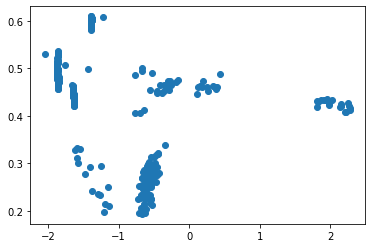

In [66]:
plt.scatter(kernel_features, final_ldos[:,400].detach())

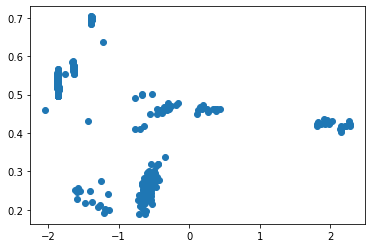

In [67]:
plt.scatter(kernel_features, o_ldos[small_index,400].detach())

In [59]:
sigma = torch.tensor(0.3)
dx = 0.05

emin = -24.5537
emax = 11.3464


ndos = int((emax-emin+3) / dx) #number of points
xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos = torch.zeros((len(small_index), ndos))
for i in tqdm(range(len(small_index))):#for every structure    
    ldos[i] = torch.sum(torch.exp(-0.5*((alignment[i] + xdos - full_eigen_energies[small_index[i]].view(-1,1))/sigma)**2), dim = 0)

final_ldos = ((ldos.T * normalization ).T)* 2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:03<00:00, 126.45it/s]


In [27]:
final_ldos.shape

torch.Size([435, 778])

In [ ]:
plt.plot()

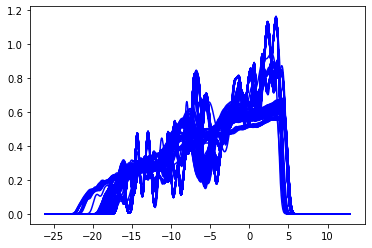

In [64]:
%matplotlib inline
index = 50
for index in range(len(small_index)):
    #plt.plot(xdos, o_ldos[small_index[index]], c = 'r')
    plt.plot(xdos, final_ldos[index].detach(), c = 'b')

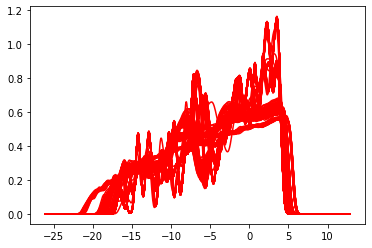

In [65]:
%matplotlib inline
index = 50
for index in range(len(small_index)):
    plt.plot(xdos, o_ldos[small_index[index]], c = 'r')
    #plt.plot(xdos, final_ldos[index].detach(), c = 'b')

torch.corrcoef
torch.var

tensor(52)


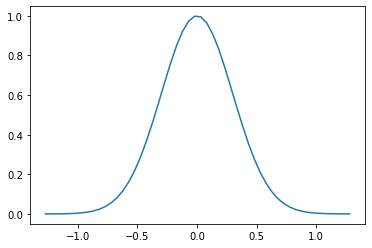

In [214]:
tol = 1E-4
print (torch.sum(test_ldos > tol))

plt.plot(xdos[(test_ldos > tol)], test_ldos[(test_ldos > tol)])

In [216]:
xdos[(test_ldos > tol)]

tensor([-1.2718, -1.2217, -1.1717, -1.1216, -1.0715, -1.0215, -0.9714, -0.9213,
        -0.8713, -0.8212, -0.7711, -0.7211, -0.6710, -0.6209, -0.5709, -0.5208,
        -0.4707, -0.4207, -0.3706, -0.3206, -0.2705, -0.2204, -0.1704, -0.1203,
        -0.0702, -0.0202,  0.0299,  0.0800,  0.1300,  0.1801,  0.2302,  0.2802,
         0.3303,  0.3803,  0.4304,  0.4805,  0.5305,  0.5806,  0.6307,  0.6807,
         0.7308,  0.7809,  0.8309,  0.8810,  0.9311,  0.9811,  1.0312,  1.0813,
         1.1313,  1.1814,  1.2314,  1.2815])

In [212]:
ldos[0]

tensor([6.3422e-155, 5.0089e-153, 3.8472e-151, 2.8738e-149, 2.0878e-147,
        1.4751e-145, 1.0136e-143, 6.7735e-142, 4.4023e-140, 2.7826e-138,
        1.7105e-136, 1.0226e-134, 5.9460e-133, 3.3623e-131, 1.8491e-129,
        9.8900e-128, 5.1445e-126, 2.6026e-124, 1.2805e-122, 6.1272e-121,
        2.8514e-119, 1.2906e-117, 5.6807e-116, 2.4319e-114, 1.0125e-112,
        4.0999e-111, 1.6146e-109, 6.1840e-108, 2.3035e-106, 8.3453e-105,
        2.9404e-103, 1.0076e-101, 3.3580e-100,  1.0885e-98,  3.4313e-97,
         1.0520e-95,  3.1370e-94,  9.0977e-93,  2.5661e-91,  7.0396e-90,
         1.8782e-88,  4.8739e-87,  1.2301e-85,  3.0194e-84,  7.2086e-83,
         1.6738e-81,  3.7801e-80,  8.3031e-79,  1.7738e-77,  3.6858e-76,
         7.4489e-75,  1.4642e-73,  2.7993e-72,  5.2054e-71,  9.4147e-70,
         1.6562e-68,  2.8339e-67,  4.7164e-66,  7.6348e-65,  1.2021e-63,
         1.8411e-62,  2.7426e-61,  3.9740e-60,  5.6011e-59,  7.6789e-58,
         1.0240e-56,  1.3284e-55,  1.6761e-54,  2.0

In [154]:
sigma = torch.tensor(0.3)
dx = 0.05

ndos = int((emax-emin+3) / dx) #number of points
xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos = torch.zeros((len(full_eigen_energies), ndos))
for i in tqdm(range(len(full_eigen_energies))):#for every structure    
    for ei in full_eigen_energies[i]:#for every energy level
        ldos[i] += torch.exp(-0.5*((xdos[:]-ei)/sigma)**2) #puts a gaussian centered on the energy level
    ldos[i] *= 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms[i]/len(full_eigen_energies[i]) #normalize

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [13:33<00:00,  1.28it/s]


In [181]:
sigma = torch.tensor(0.3)
dx = 0.05

ndos3 = int((emax-emin+3) / dx) #number of points
xdos3 = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos3 = torch.zeros((len(full_eigen_energies), ndos))
for i in tqdm(range(len(eigen_energies))):#for every structure    
    for ei in full_eigen_energies[i]:#for every energy level
        ldos3[i] += torch.exp(-0.5*((xdos[:]-ei)/sigma)**2) #puts a gaussian centered on the energy level
    ldos3[i] *= 1/torch.sqrt(2*np.pi*sigma**2)/n_atoms[i]/len(eigen_energies[i]) #normalize

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [13:40<00:00,  1.27it/s]


In [156]:
ldos.shape

torch.Size([1039, 778])

In [155]:
load_ldos = torch.tensor(data.load_ldos())

In [157]:
load_ldos.shape

torch.Size([1039, 778])

In [182]:
torch.sum(ldos3 - load_ldos)

tensor(1.8786e-11)

tensor([6.3422e-155, 5.0089e-153, 3.8472e-151, 2.8738e-149, 2.0878e-147,
        1.4751e-145, 1.0136e-143, 6.7735e-142, 4.4023e-140, 2.7826e-138,
        1.7105e-136, 1.0226e-134, 5.9460e-133, 3.3623e-131, 1.8491e-129,
        9.8900e-128, 5.1445e-126, 2.6026e-124, 1.2805e-122, 6.1272e-121,
        2.8514e-119, 1.2906e-117, 5.6807e-116, 2.4319e-114, 1.0125e-112,
        4.0999e-111, 1.6146e-109, 6.1840e-108, 2.3035e-106, 8.3453e-105,
        2.9404e-103, 1.0076e-101, 3.3580e-100,  1.0885e-98,  3.4313e-97,
         1.0520e-95,  3.1370e-94,  9.0977e-93,  2.5661e-91,  7.0396e-90,
         1.8782e-88,  4.8739e-87,  1.2301e-85,  3.0194e-84,  7.2086e-83,
         1.6738e-81,  3.7801e-80,  8.3031e-79,  1.7738e-77,  3.6858e-76,
         7.4489e-75,  1.4642e-73,  2.7993e-72,  5.2054e-71,  9.4147e-70,
         1.6562e-68,  2.8339e-67,  4.7164e-66,  7.6348e-65,  1.2021e-63,
         1.8411e-62,  2.7426e-61,  3.9740e-60,  5.6011e-59,  7.6789e-58,
         1.0240e-56,  1.3284e-55,  1.6761e-54,  2.0

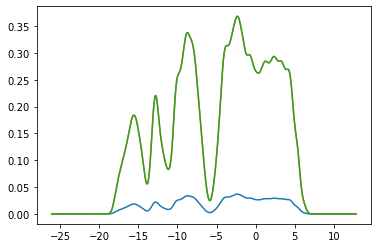

In [173]:
plt.plot(xdos, ldos[0])
plt.plot(xdos, load_ldos[0])
plt.plot(xdos, ldos2[0]/2)

In [151]:
len(full_eigen_energies)

1039

In [150]:
n_atoms

array([ 2,  2,  2, ..., 64, 64, 64])

In [149]:
full_eigen_energies[0].shape

torch.Size([17280])

(array([ 871.,  976., 1260., 2222., 1576., 1416., 2839., 2357., 2409.,
        1354.]),
 array([-18.17461078, -15.72919256, -13.28377434, -10.83835611,
         -8.39293789,  -5.94751967,  -3.50210145,  -1.05668323,
          1.388735  ,   3.83415322,   6.27957144]),
 <BarContainer object of 10 artists>)

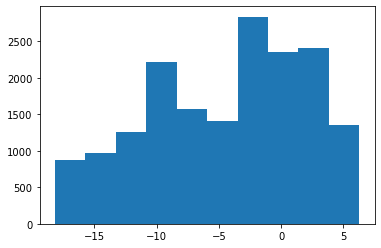

In [128]:
%matplotlib inline
plt.hist(full_eigen_energies[0])

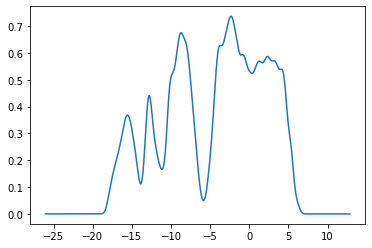

In [126]:
plt.plot(xdos, ldos[0])

In [119]:
full_eigen_energies[800]

array([-16.60588, -16.54909, -15.54305, -15.45937, -15.45121, -15.43287,
       -15.32074, -14.61737, -14.33326, -14.29375, -14.05621, -14.00797,
       -13.93545, -13.64648, -13.61615, -13.38318, -13.26855, -13.24025,
       -13.17384, -12.707  , -12.59452, -12.56104, -12.45239, -11.76678,
       -11.67876, -11.59029, -11.34739, -11.26894, -11.21269, -10.98213,
       -10.69638, -10.66462, -10.31505, -10.21668,  -9.91014,  -9.86218,
        -9.80729,  -9.78614,  -9.58256,  -9.53331,  -9.487  ,  -9.36825,
        -9.33584,  -9.31106,  -9.14733,  -8.43683,  -8.27836,  -8.2237 ,
        -8.12477,  -8.06293,  -7.90795,  -7.86268,  -7.56618,  -7.48181,
        -7.34864,  -7.30863,  -7.26979,  -7.25031,  -7.21767,  -7.16886,
        -7.11855,  -7.1168 ,  -7.11524,  -7.01444,  -6.89008,  -6.85225,
        -6.78634,  -6.78052,  -6.65848,  -6.59779,  -6.44407,  -6.43024,
        -6.36549,  -6.30418,  -5.97351,  -5.90463,  -5.81469,  -5.79334,
        -5.75529,  -5.73908,  -5.7175 ,  -5.65801, 

In [114]:
#find a way to maximize certain peaks based on normalization weights

normalization_weights = []
for i in range(n_structures):
    value = 1/np.sqrt(2*np.pi*gb**2)/n_atoms[i]/eigenenergy_length[i] #normalize
    normalization_weights.append(value)

In [118]:
for i,j in enumerate(normalization_weights):
    print (i, j)

0 3.847822920538509e-05
1 3.847822920538509e-05
2 3.847822920538509e-05
3 3.847822920538509e-05
4 3.847822920538509e-05
5 3.847822920538509e-05
6 3.847822920538509e-05
7 3.847822920538509e-05
8 3.847822920538509e-05
9 3.847822920538509e-05
10 3.847822920538509e-05
11 3.847822920538509e-05
12 3.847822920538509e-05
13 3.847822920538509e-05
14 3.847822920538509e-05
15 3.847822920538509e-05
16 3.847822920538509e-05
17 3.847822920538509e-05
18 3.847822920538509e-05
19 3.847822920538509e-05
20 3.847822920538509e-05
21 3.847822920538509e-05
22 3.847822920538509e-05
23 3.847822920538509e-05
24 3.847822920538509e-05
25 3.847822920538509e-05
26 3.847822920538509e-05
27 3.847822920538509e-05
28 3.847822920538509e-05
29 3.847822920538509e-05
30 3.847822920538509e-05
31 3.847822920538509e-05
32 3.847822920538509e-05
33 3.847822920538509e-05
34 3.847822920538509e-05
35 3.847822920538509e-05
36 3.847822920538509e-05
37 3.847822920538509e-05
38 3.847822920538509e-05
39 3.847822920538509e-05
40 3.84782

In [108]:
for i,j in enumerate(eigenenergy_length):
    print (i, j)

0 17280
1 17280
2 17280
3 17280
4 17280
5 17280
6 17280
7 17280
8 17280
9 17280
10 17280
11 17280
12 17280
13 17280
14 17280
15 17280
16 17280
17 17280
18 17280
19 17280
20 17280
21 17280
22 17280
23 17280
24 17280
25 17280
26 17280
27 17280
28 17280
29 17280
30 17280
31 17280
32 17280
33 17280
34 17280
35 17280
36 17280
37 17280
38 17280
39 17280
40 17280
41 17280
42 17280
43 17280
44 17280
45 17280
46 17280
47 17280
48 17280
49 17280
50 17280
51 17280
52 17280
53 17280
54 17280
55 17280
56 17280
57 20160
58 17280
59 17280
60 17280
61 17280
62 17280
63 20160
64 17280
65 17280
66 17280
67 20160
68 17280
69 20160
70 20160
71 17280
72 20160
73 23520
74 17280
75 17280
76 17280
77 17280
78 17280
79 20160
80 17280
81 23520
82 17280
83 17280
84 17280
85 23520
86 20160
87 17280
88 17280
89 20160
90 23520
91 20160
92 20160
93 23520
94 20160
95 17280
96 23520
97 20160
98 20160
99 23520
100 20160
101 23520
102 17280
103 23520
104 17280
105 17280
106 17280
107 17280
108 17280
109 17280
110 17280


In [101]:
eigen_energies[0].flatten()

array([-18.17461078,  -6.44173492,  -6.11571398, ...,  -1.60998269,
         1.12160967,   2.04909942])

In [ ]:
eigen_energies

In [96]:
len(eigen_energies[0][1])

10

In [95]:
len(eigen_energies[700][0])

165

In [87]:
eigenenergy_length[700]

1

In [110]:
plt.plot(xdos, ldos[0])

In [139]:
from sklearn.decomposition import PCA

soap = Silicon.Features['structure_avedescriptors'] 
soap_pca = PCA(n_components = 1, svd_solver = "full")
soap_pca.fit(soap)

print ("SOAP PCA explained variance with 1 PCA is: {}".format(soap_pca.explained_variance_ratio_))

PCA_soap = soap_pca.transform(soap)

kernel = Silicon.Features['structure_avekerneldescriptors']
kernel_pca = PCA(n_components = 1, svd_solver = "full")
kernel_pca.fit(kernel)

print ("Kernel PCA explained variance with 1 PCA is: {}".format(kernel_pca.explained_variance_ratio_))

PCA_kernel = kernel_pca.transform(kernel)

SOAP PCA explained variance with 1 PCA is: [0.85417772]
Kernel PCA explained variance with 1 PCA is: [0.76640756]


In [146]:
soap_pca.components_

array([[-3.49913423e-03, -1.76411215e-02,  3.32522948e-02,
         3.61629233e-01,  1.87222390e-01,  7.49472932e-02,
         7.73753721e-02,  2.89413546e-02, -1.76411215e-02,
         7.01613627e-04, -6.64714922e-03, -1.96539716e-02,
        -1.21993389e-02, -6.67081254e-03, -4.36700539e-03,
        -1.68577363e-03,  3.32522948e-02, -6.64714922e-03,
         2.20352739e-02,  1.41889410e-01,  7.26851954e-02,
         3.15241013e-02,  2.88627511e-02,  1.08549650e-02,
         3.61629233e-01, -1.96539716e-02,  1.41889410e-01,
         4.92546963e-01,  2.89406316e-01,  1.51981690e-01,
         1.06534352e-01,  4.10607729e-02,  1.87222390e-01,
        -1.21993389e-02,  7.26851954e-02,  2.89406316e-01,
         1.62030561e-01,  8.08235013e-02,  6.02749031e-02,
         2.31914869e-02,  7.49472932e-02, -6.67081254e-03,
         3.15241013e-02,  1.51981690e-01,  8.08235013e-02,
         3.70043392e-02,  3.02939232e-02,  1.15274716e-02,
         7.73753721e-02, -4.36700539e-03,  2.88627511e-0

## Baseline Model (Kernel) and Comparison

In [58]:
from sklearn.linear_model import Ridge
from dostools.loss import loss
from dostools.consistency import consistency

#Features = copy.deepcopy(Silicon.Features["structure_avekerneldescriptors"])
Features = copy.deepcopy(PCA_kernel)
o_ldos = torch.tensor(data.load_ldos())
o_ldos *= 2
y_pw = o_ldos# - o_ldos[train_index].mean(axis = 0)
y_shifted = copy.deepcopy(y_pw)
#y_shifted = consistency.shifted_ldos()

baselinemodel = Ridge(alpha = 0, fit_intercept = True, solver = 'svd')

x = Features[small_index]
y = y_shifted[small_index]

baselinemodel.fit(x,y)

baseline_predictions = baselinemodel.predict(x)
train_rmse = loss.t_get_rmse(torch.tensor(baseline_predictions), y)

small_test_index = torch.arange(1039)
small_test_index[small_index] = False
small_test_index = small_test_index.nonzero().flatten()


baseline_test_predictions = baselinemodel.predict(Features[small_test_index])
test_rmse = loss.t_get_rmse(torch.tensor(baseline_test_predictions), y_shifted[small_test_index])

print(train_rmse)
print(test_rmse)

tensor(0.0458)
tensor(0.1024)


In [60]:
from sklearn.linear_model import Ridge
from dostools.loss import loss
from dostools.consistency import consistency

# Features = copy.deepcopy(Silicon.Features["structure_avekerneldescriptors"])
Features = copy.deepcopy(PCA_kernel)
n_ldos = torch.tensor(final_ldos)
n_ldos *= 2
y_pw = n_ldos# - o_ldos[train_index].mean(axis = 0)
y_shifted = copy.deepcopy(y_pw.clone())
#y_shifted = consistency.shifted_ldos()

baselinemodel = Ridge(alpha = 0, fit_intercept = True, solver = 'svd')

x = Features[small_index]
y = y_shifted

baselinemodel.fit(x,y)

baseline_predictions = baselinemodel.predict(x)
train_rmse = loss.t_get_rmse(torch.tensor(baseline_predictions), y)

small_test_index = torch.arange(1039)
small_test_index[small_index] = False
small_test_index = small_test_index.nonzero().flatten()


#baseline_test_predictions = baselinemodel.predict(Features[small_test_index])
#test_rmse = loss.t_get_rmse(torch.tensor(baseline_test_predictions), y_shifted[small_test_index])

print(train_rmse)
#print(test_rmse)

tensor(0.0943)


/tmp/ipykernel_41760/2171692042.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_ldos = torch.tensor(final_ldos)


In [48]:
small_index.shape

torch.Size([435, 1])

In [46]:
small_test_index

tensor([[  1],
        [  2],
        [  3],
        [  4],
        [  5],
        [  6],
        [  7],
        [  8],
        [  9],
        [ 10],
        [ 11],
        [ 12],
        [ 13],
        [ 14],
        [ 15],
        [ 16],
        [ 17],
        [ 18],
        [ 19],
        [ 20],
        [ 21],
        [ 22],
        [ 23],
        [ 24],
        [ 25],
        [ 26],
        [ 27],
        [ 28],
        [ 29],
        [ 30],
        [ 31],
        [ 32],
        [ 33],
        [ 34],
        [ 35],
        [ 36],
        [ 37],
        [ 38],
        [ 39],
        [ 40],
        [ 41],
        [ 42],
        [ 43],
        [ 44],
        [ 45],
        [ 46],
        [ 47],
        [ 48],
        [ 49],
        [ 50],
        [ 51],
        [ 52],
        [ 53],
        [ 54],
        [ 55],
        [ 56],
        [ 57],
        [ 58],
        [ 59],
        [ 60],
        [ 61],
        [ 62],
        [ 63],
        [ 64],
        [ 65],
        [ 66],
        [ 

## Generate data

<IPython.core.display.Javascript object>


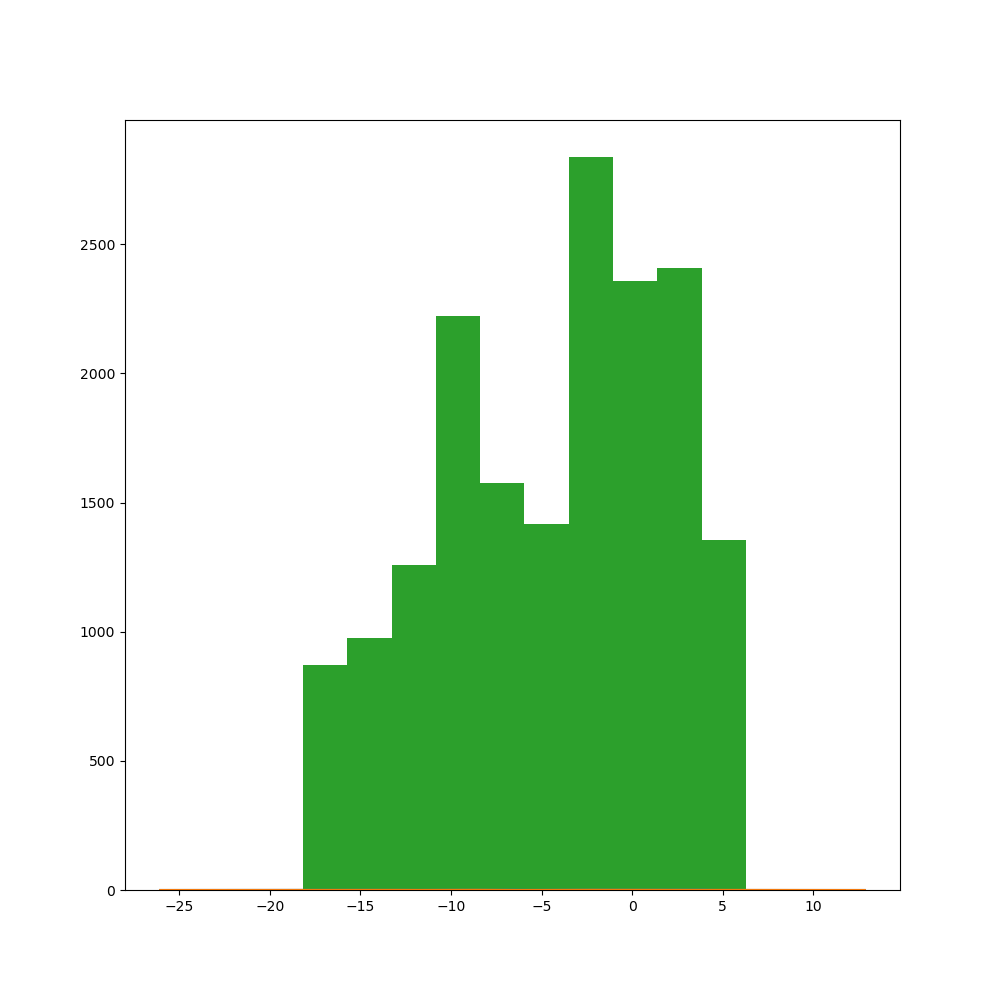

In [109]:
plt.plot(xdos, ldos[700])